In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format="retina"

# Q1 

In [22]:
x = np.array([1, -1, -1])[None,:]
x

array([[ 1, -1, -1]])

In [23]:
weight_input2hidden = np.array([[-30, 20, 20], [10, -20, -20]]).T
weight_input2hidden

array([[-30,  10],
       [ 20, -20],
       [ 20, -20]])

In [24]:
weight_hidden2final = np.array([-10, 20, 20])[:, None]
weight_hidden2final

array([[-10],
       [ 20],
       [ 20]])

In [26]:
def activation(x): return 1 if x>0 else 0

# vectorize so can broadcast to each element
activation_vec = np.vectorize(activation)

In [27]:
hidden_input = x.dot(weight_input2hidden)
hidden_output = activation_vec(hidden_input)
hidden_output

array([[0, 1]])

In [28]:
final_input = np.insert(hidden_output, 0, 1).dot(weight_hidden2final)
final_output = activation_vec(final_input)
final_output

array([1])

So the prediction is 1.

---

# Q2 

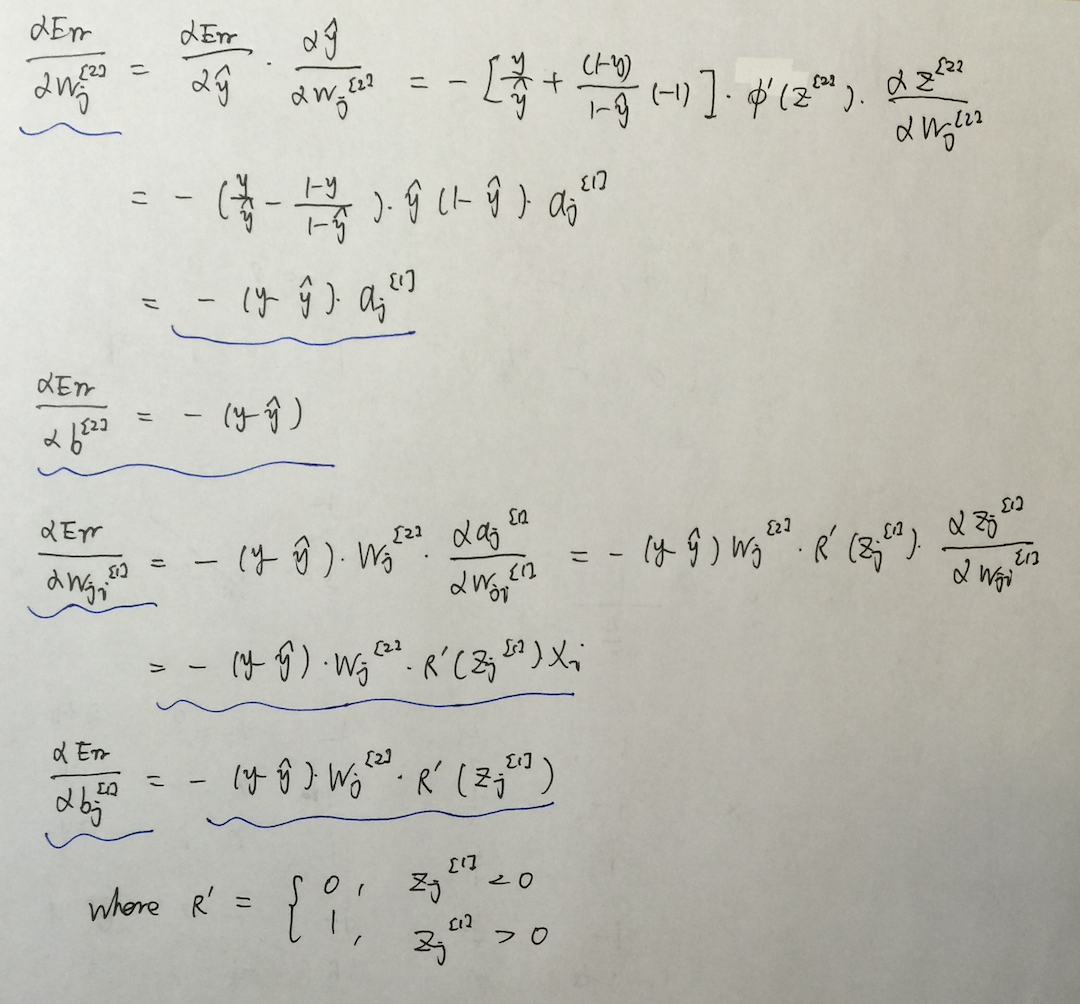

---

# Q3

In [2]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset

**Load MNIST**

In [3]:
train_ds = datasets.MNIST('../data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('../data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

batch_size = 64
#batch_size = 5 # for testing
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)

**Neural Network**

In [4]:
# for the number of neurons in the hidden unit
def get_model(M = 300):
    net = nn.Sequential(nn.Linear(28*28, M),
                        nn.ReLU(),
                        nn.Linear(M, 10))
    return net.cuda()

In [5]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    for epoch in range(num_epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = Variable(images.view(-1, 28*28)).cuda()
            labels = Variable(labels).cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.data[0]  # sum loss: cumulative loss over batches
#             if (i+1) % 100 == 0:
#                 print ('Epoch [%d/%d], Loss: %.4f' 
#                    %(epoch+1, num_epochs, sum_loss/total))
                
        train_loss = sum_loss/total
#         print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
#         print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
    return val_acc, val_loss, train_loss

In [6]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        images = Variable(images.view(-1, 28*28)).cuda()
        labels = Variable(labels).cuda()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.data[0]
        total += labels.size(0)
        correct += pred.eq(labels.data).cpu().sum()
    return 100 * correct / total, sum_loss/ total

## Q3.1

Fine tune learning rate.

In [14]:
learning_rate_list = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
val_acc_list = []

for lr in learning_rate_list:
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    val_acc, _, _ = train_model(train_loader, 
                                test_loader, 
                                num_epochs=10, 
                                model=net, 
                                optimizer=optimizer)
    val_acc_list.append(val_acc)

In [19]:
val_acc_table = pd.DataFrame({'lr': learning_rate_list, 
                              'val_acc': val_acc_list}).\
                   sort_values('val_acc', ascending=False).\
                   reset_index(drop=True)
val_acc_table

,lr,val_acc
0,0.00100,97.79
1,0.00010,97.67
2,0.01000,95.65
3,0.00001,92.79
4,0.10000,9.84
5,1.00000,9.74


So the best two learnign rates are 1e-3 and 1e-4.  
Let's try using 0.0005.

In [20]:
net = get_model()
optimizer = optim.Adam(net.parameters(), lr = 5e-4)
val_acc, _, _ = train_model(train_loader,
                            test_loader, 
                            num_epochs = 10, 
                            model=net,
                            optimizer = optimizer)
print(val_acc)

97.8


So the accuracy is 97.8% after interpolating between two best learning rates.

## Q3.2

Fine tuning number of nodes in the hidden layer.

In [10]:
n_nodes = [10, 50, 100, 300, 1000, 2000]
val_acc_list = []
val_loss_list = []
train_loss_list  = []

for M in n_nodes:
    net = get_model(M)
    optimizer = optim.Adam(net.parameters(), lr = 1e-2)
    val_acc, val_loss, train_loss = train_model(train_loader,
                                                test_loader, 
                                                num_epochs = 10, 
                                                model=net,
                                                optimizer = optimizer)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    train_loss_list.append(train_loss)

In [12]:
val_acc_table2 = pd.DataFrame({'n_nodes': n_nodes, 
                               'val_acc': val_acc_list,
                               'val_loss': val_loss_list,
                               'train_loss': train_loss_list}).\
                    sort_values('val_acc', ascending=False).\
                    reset_index(drop=True)
val_acc_table2[['n_nodes', 'val_acc', 'train_loss', 'val_loss']]

,n_nodes,val_acc,train_loss,val_loss
0,2000,95.45,0.199288,0.250111
1,100,95.35,0.185510,0.236501
2,50,95.05,0.188871,0.228933
3,1000,94.85,0.190755,0.268865
4,300,94.44,0.183679,0.331101
5,10,92.42,0.301932,0.292413


- Hidden layer with 2000 nodes achieves the best performance. 
- According to `train_loss` and `val_loss`, model with nodes [50, 100, 300, 1000, 2000] are overfitting.

## Q3.3

L2 regularization with different weight decay.

In [13]:
weight_decay_list = [0, 1e-4, 1e-3, 1e-2, 1e-1, 3e-1]
M = 300
lr = 1e-3
n_epoch = 20
val_acc_list = []
val_loss_list = []
train_loss_list  = []

for w in weight_decay_list:
    net = get_model(M)
    optimizer = optim.Adam(net.parameters(), 
                           lr = lr,
                           weight_decay = w)
    val_acc, val_loss, train_loss = train_model(train_loader,
                                                test_loader, 
                                                num_epochs = n_epoch, 
                                                model=net,
                                                optimizer = optimizer)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    train_loss_list.append(train_loss)

In [21]:
val_acc_table3 = pd.DataFrame({'weight_decay': weight_decay_list, 
                               'val_acc': val_acc_list,
                               'val_loss': val_loss_list,
                               'train_loss': train_loss_list}).\
                    sort_values('val_acc', ascending=False).\
                    reset_index(drop=True)
val_acc_table3[['weight_decay', 'val_acc', 'train_loss', 'val_loss']]

,weight_decay,val_acc,train_loss,val_loss
0,0.0000,97.98,0.033797,0.122423
1,0.0001,97.79,0.040454,0.083753
2,0.0010,97.73,0.071043,0.071412
3,0.0100,95.61,0.169062,0.151116
4,0.1000,90.44,0.470033,0.433612
5,0.3000,85.04,0.819912,0.791775


The validation accuracy is lower after using L2 regularization.

## Q3.4 

Dropout

In [7]:
def get_model_v2(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules).cuda()

In [8]:
drop_prob = [0.0, 0.2, 0.5, 0.6, 0.8]
M = 300
lr = 1e-3
n_epoch = 20
val_acc_list = []
val_loss_list = []
train_loss_list  = []

for p in drop_prob:
    net2 = get_model_v2(M, p)
    optimizer = optim.Adam(net2.parameters(), lr=lr)
    val_acc, val_loss, train_loss = train_model(train_loader,
                                                test_loader, 
                                                num_epochs = n_epoch, 
                                                model=net2,
                                                optimizer = optimizer)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    train_loss_list.append(train_loss)

In [9]:
val_acc_table4 = pd.DataFrame({'drop_prob': drop_prob, 
                               'val_acc': val_acc_list,
                               'val_loss': val_loss_list,
                               'train_loss': train_loss_list}).\
                    sort_values('val_acc', ascending=False).\
                    reset_index(drop=True)
val_acc_table4[['drop_prob', 'val_acc', 'train_loss', 'val_loss']]

,drop_prob,val_acc,train_loss,val_loss
0,0.6,98.20,0.042400,0.102656
1,0.0,98.17,0.033304,0.105755
2,0.8,97.96,0.054519,0.114012
3,0.5,97.80,0.039437,0.131167
4,0.2,97.72,0.035075,0.135168


- We can see that drop_prob=0.6 achieves the best performance, and performs better than the model without dropout layer. 
- With a dropout rate 0.6, the model achieves the balance between bias and variance. That is the reason it performs best.
- Compared to L2 regularization, dropout has better accuracy.

## Q3.5 

Build a 3 layer neural network.

In [11]:
def get_model_v3():
    net = nn.Sequential(
                        nn.Linear(28*28, 512),
                        nn.ReLU(),
                        nn.Dropout(0.2),
            
                        nn.Linear(512, 512),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        
                        nn.Linear(512, 10)
                      )
    return net.cuda()

net3 = get_model_v3()
optimizer = optim.Adam(net3.parameters(), lr=1e-3)
val_acc, val_loss, train_loss = train_model(train_loader, 
                                            test_loader, 
                                            num_epochs=20, 
                                            model=net3, 
                                            optimizer=optimizer)

In [12]:
print(val_acc)

98.36


With a typical 3 layers neural network, we achieve 98.36% accuracy.